<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/UQ_training_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_probability as tfp

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git


fatal: destination path 'neuraluq' already exists and is not an empty directory.


In [ ]:
tf.__version__

'2.13.0'

In [ ]:
tfp.__version__

'0.20.1'

In [ ]:
import neuraluq.neuraluq as neuq

In [ ]:
import neuraluq.neuraluq as neuq
import neuraluq.neuraluq.variables as neuq_vars
from neuraluq.neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

#**For pharmacokinetic problem**

In [ ]:
def load_data():
    t_d = np.array([0, 1, 2, 4, 7, 14]).reshape([-1, 1])
    Q1 = np.array([1, 0.582, 0.402, 0.389, 0.3884, 0.3880]).reshape([-1, 1])
    Q2 = np.array([0, 0.418, 0.598, 0.611, 0.6115, 0.612]).reshape([-1, 1])
    return t_d, Q1, Q2


def sird(t, u, ft):

    V1 = 254.5
    V2 = 1000
    f1 = 0.0

    # Q1, Q2, ft = tf.split(u, 3, axis=-1)
    Q1, Q2 = tf.split(u, 2, axis=-1)
    ft = ft

    # k = nn.softplus(ft)
    k  = ft
    Q1_t = tf.gradients(Q1, t)[0]
    Q2_t = tf.gradients(Q2, t)[0]

    f1 = Q1_t + k * (Q1/V1 - Q1/V2)- f1
    f2 = Q2_t - k * (Q1/V1 - Q2/V2)
    print(f1.shape, f2.shape)

    return tf.concat([f1, f2], axis=-1)


def scaling(inputs, a=1, b=0):
    """Applies linear transformation, i.e. a*inputs + b."""
    return a * inputs + b


# def Samplable(t_u_train, u_train, t_f_train, f_train, noise, N, layers_u, layers_bgn):
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft):
    # layers_beta = layers_gamma = layers_nu = layers_bgn
    # build processes
    input_scaling = lambda inputs: scaling(inputs, a=0.01)
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_u,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_u, mean=0, sigma=0.2),
    )
    process_ft = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_ft,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_ft, mean=0, sigma=0.2),
    )

    # build likelihood
    likelihood_u = neuq.likelihoods.Normal(
        inputs=t_u_train, targets=u_train, processes=[process_u,process_ft], sigma=noise,
    )
    # inputs=t_u_train, targets=u_train, processes=[process_u], sigma=noise, out_dims=[[0, 1]]
    # print(f_train.shape, t_f_train.shape)

    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_ft],
        pde=lambda *args: sird(*args),
        sigma=0.02,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_ft],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    # Change the parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=2000,
        init_time_step=0.01,
        leapfrog_step=100,
        seed=666,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: ", np.mean(results))

    processes = [process_u, process_ft]
    return processes, samples, model


@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft):

    # build processes
    input_scaling = lambda inputs: scaling(inputs, a=0.01)
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_u,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_u),
    )
    process_ft = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_ft,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_ft),
    )

    # build losses
    loss_u = neuq.likelihoods.MSE(
        inputs=t_u_train, targets=u_train, processes=[process_u], multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_ft],
        pde=lambda *args: sird(*args),
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_ft],
        likelihoods=[loss_u, loss_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=10, num_iterations=30000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_ft]
    return processes, samples, model

In [ ]:
t, Q1, Q2 = load_data()
t_train, Q1_train, Q2_train = t, Q1, Q2
t_f_train, f_train = t_train.copy(), np.zeros([Q1.shape[0], 2])
t_test, Q1_test, Q2_test = t, Q1, Q2

In [ ]:
scale = 1
# N = (n / scale).astype(np.float32)
Q1_train, Q2_train = Q1_train / scale, Q2_train / scale
# t_train, I_train, R_train, D_train = t_train[::4], I_train[::4], R_train[::4], D_train[::4]
u_train = np.concatenate([Q1_train, Q2_train], axis=-1)

layers_u = [1, 50, 50, 50, 2]  # layers for SIRD
layers_ft = [1, 20,20, 1]  # layers for ft
noise = 0.1

In [ ]:
# processes, samples, model = Samplable(
#     t_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft,
# )
processes, samples, model = Trainable(
    t_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft,
)


Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

(6, 1) (6, 1)
Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  0.08694139
Iteration:  1000 , loss:  0.0075312257
Iteration:  2000 , loss:  0.0007734875
Iteration:  3000 , loss:  0.00027101344
Iteration:  4000 , loss:  1.1485639e-05
Iteration:  5000 , loss:  2.4874764e-06
Iteration:  6000 , loss:  1.6166778e-06
Iteration:  7000 , loss:  1.2344229e-06
Iteration:  8000 , loss:  1.1386234e-06
Iteration:  9000 , loss:  3.8351377e-06
Iteration:  10000 , loss:  3.1599945e-06
Iteration:  11000 , loss:  5.3729e-07
Iteration:  12000 , loss:  2.910599e-06
Iteration:  13000 , loss:  4.473041e-06
Iteration:  14000 , loss:  1.6088959e-06
Iteration:  15000 , loss:  1.0234198e-06
Iteration:  16000 , loss:  8.148313e-07
Iteration:  17000 , loss:  7.042053e-07
Iteration:  18000 , loss:  6.065771e-07
Iteration:  19000 , loss:  5.154472e-07
Iteration:  20000 , loss:  4.4076856e-07
Iteration:  21000 , loss:  5.669225e-07


In [ ]:
u_pred, f_pred = model.predict(
    t_test, samples, processes, pde_fn=None)

Q1_pred, Q2_pred= np.split(u_pred, 2, axis=-1)

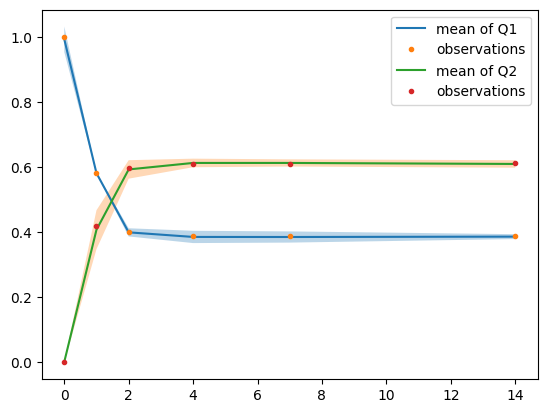

In [ ]:
mu_Q1 = np.mean(Q1_pred, axis=0) * scale
std_Q1 = np.std(Q1_pred, axis=0) * scale
mu_Q2 = np.mean(Q2_pred, axis=0) * scale
std_Q2 = np.std(Q2_pred, axis=0) * scale
mu_f = np.mean(f_pred, axis=0) * scale
std_f = np.std(f_pred, axis=0) * scale
# plt.plot(t_test, Q1, label="reference of Q1")
plt.plot(t_test, mu_Q1, label="mean of Q1")
# plt.plot(t_test, Q1_pred, label="mean of Q1")
plt.plot(t_train, Q1_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_Q1 + 2 * std_Q1).reshape([-1]),
    (mu_Q1 - 2 * std_Q1).reshape([-1]),
    alpha=0.3,
)
# plt.plot(t_test, Q2, label="reference of Q2")
plt.plot(t_test, mu_Q2, label="mean of Q2")
plt.plot(t_train, Q2_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_Q2 + 2 * std_Q2).reshape([-1]),
    (mu_Q2 - 2 * std_Q2).reshape([-1]),
    alpha=0.3,
)
# plt.plot(t_test, f_pred, label="reference of R")
# plt.plot(t_test, mu_f, label="mean of D (re-scaled)")
# # plt.plot(t_train, f_train * scale, ".", label="observations")
# plt.fill_between(
#     t_test.reshape([-1]),
#     (mu_f + 2 * std_f).reshape([-1]),
#     (mu_f - 2 * std_f).reshape([-1]),
#     alpha=0.3,
# )
# plt.plot(t_test, f, label="reference of D")
plt.legend()
plt.show()

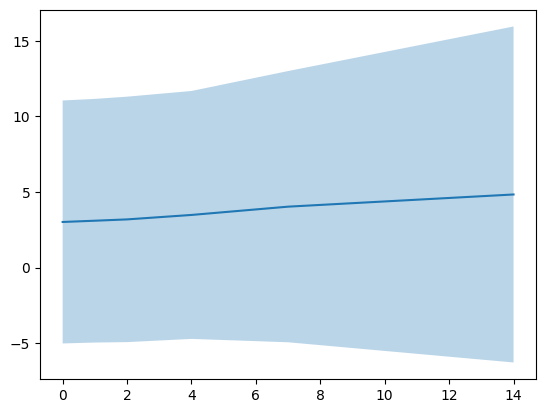

In [ ]:
mu_f = np.mean(f_pred, axis=0) * scale
std_f = np.std(f_pred, axis=0) * scale
# plt.plot(t_test, f_pred, label="reference of f")
plt.plot(t_test, mu_f, label="mean of f")
# plt.plot(t_train, f_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_f + 2 * std_f).reshape([-1]),
    (mu_f - 2 * std_f).reshape([-1]),
    alpha=0.3,
)